In [11]:
import pandas as pd
import numpy as np
from functools import lru_cache
import ssl
import certifi

In [12]:
# Set the CA bundle file
ssl._create_default_https_context = ssl._create_unverified_context
ssl._create_default_https_context().load_verify_locations(certifi.where())

@lru_cache(maxsize=None)  
def fetch_data_from_source(file):
    '''
    Files:
        f1sim-data-2022.parquet
        f1sim-data-2023.parquet
        
        f1sim-data-dictionary.xlsx
        
        f1sim-ref-left.csv
        f1sim-ref-line.csv
        f1sim-ref-right.csv
        f1sim-ref-turns.csv
    '''
    if file.split(".")[1] == "parquet":
        df = pd.read_parquet(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}")
    elif file.split(".")[1] == "csv":
        df = pd.read_csv(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}")
    elif file.split(".")[1] == "xlsx":
        df = pd.read_excel(f"https://data3001-racing.s3.ap-southeast-2.amazonaws.com/{file}") 
    return df

In [13]:
# Load data files
f1_2022_df = fetch_data_from_source('f1sim-data-2022.parquet')
f1_2023_df = fetch_data_from_source("f1sim-data-2023.parquet")
ref_left = fetch_data_from_source("f1sim-ref-left.csv")
ref_line = fetch_data_from_source("f1sim-ref-line.csv")
ref_right = fetch_data_from_source("f1sim-ref-right.csv")
ref_turns = fetch_data_from_source("f1sim-ref-turns.csv")

In [14]:
sessions = f1_2022_df['SESSION_IDENTIFIER'].tolist()
sessions = list(set(sessions))
session = f1_2022_df[f1_2022_df['SESSION_IDENTIFIER'] == sessions[0]]
columns_to_print = ['SESSION_IDENTIFIER', 'FRAME', 'LAP_NUM', 'SECTOR', 'LAP_DISTANCE', 'CURRENT_LAP_TIME_MS', 'LAP_TIME_MS', 'SPEED_KPH']
session = session[columns_to_print]

session

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,LAP_TIME_MS,SPEED_KPH
376558,1.924204e+18,1012,1,0,27.757099,333,170118,295
376559,1.924204e+18,1017,1,0,49.735920,600,170118,297
376560,1.924204e+18,1027,1,0,91.468849,1101,170118,301
376561,1.924204e+18,1042,1,0,133.682373,1601,170118,305
376562,1.924204e+18,1096,1,0,310.165649,3812,170118,270
...,...,...,...,...,...,...,...,...
377516,1.924204e+18,19635,6,2,4841.431641,114545,122310,98
377517,1.924204e+18,19652,6,2,4858.050781,115146,122310,106
377518,1.924204e+18,19697,6,2,4936.539062,117198,122310,177
377519,1.924204e+18,19718,6,2,4990.382812,118199,122310,208


In [15]:
for col in f1_2022_df.columns:
    print(col)
    

SESSION_IDENTIFIER
FRAME
LAP_NUM
SECTOR
LAP_DISTANCE
CURRENT_LAP_TIME_MS
SECTOR_1_TIME_MS
SECTOR_2_TIME_MS
LAP_TIME_MS
SECTOR_3_MS
SPEED_KPH
THROTTLE
BRAKE
GEAR
ENGINE_RPM
STEERING
YAW
PITCH
ROLL
WORLDPOSX
WORLDPOSY
WORLDPOSZ
WORLDFORWARDDIRX
WORLDFORWARDDIRY
WORLDFORWARDDIRZ
WORLDRIGHTDIRX
WORLDRIGHTDIRY
WORLDRIGHTDIRZ


In [16]:
def calc_acceleration(data):
    # time in milliseconds
    times = []

    # speed in km per hour

    # acceleration is in meters per second^2
    accelerations = []

    for count, row in data.iterrows():
        sessionid1 = row['SESSION_IDENTIFIER']
        lapid1 = row['LAP_NUM']
        time1 = row['CURRENT_LAP_TIME_MS']
        speed1 = row['SPEED_KPH']
        try:
            sessionid2 = data['SESSION_IDENTIFIER'].iloc[count-1]
            lapid2 = data['LAP_NUM'].iloc[count-1]
            time2 = data['CURRENT_LAP_TIME_MS'].iloc[count-1]
            speed2 = data['SPEED_KPH'].iloc[count-1]
            
            if sessionid1 == sessionid2 and lapid1 == lapid2:
                # convert speed from km/h to m/s
                diff_speed = (speed1 - speed2) / 3.6
                
                # convert time to seconds
                time = (time1 - time2) / 1000 
                times.append(time)
                
                if time > 0:
                    acceleration = diff_speed / time 
                else:
                    acceleration = np.nan
                
                accelerations.append(acceleration)
                
                if acceleration < 0:
                    print(count)
            else:
                times.append(time1 / 1000)
                
                accelerations.append(0)
                
        except KeyError:
            times.append(np.nan)
            accelerations.append(np.nan)
    
    if 'ACCELERATION' in data.columns:
        data.drop('ACCELERATION', axis = 1, inplace = True)
    
    index = data.columns.get_loc('SPEED_KPH')
    return data.insert(index + 1, 'ACCELERATION', accelerations)

In [21]:
calc_acceleration(f1_2022_df)

1
2
3
4
18
19
27
28
42
43
58
59
60
62
68
71
72
75
82
83
84
85
89
90
91
94
95
96
105
106
131
132
133
144
164
165
166
167
168
169
170
176
188
189
190
193
197
211
216
217
218
225
234
250
257
258
259
268
269
274
275
276
277
278
279
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
375
376
377
379
380
381
382
383
384
385
387
388
389
390
391
393
394
395
396
397
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
592
598
600
601
603
604
605
606
607
608
609
610
611
612
613
615
616
617
618
619
621
622
623
673
680
681
682
683
684
685
686
688
690
744
745
746
747
749
750
751
753
754
758
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
871
878
1124
1134
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1248
1249
1387
1388
1389
1390
1391
1392
1393
1394
1

In [26]:
import matplotlib.pyplot as plt

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
f1_2022_df

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,SPEED_KPH,ACCELERATION,THROTTLE,BRAKE,GEAR,ENGINE_RPM,STEERING,YAW,PITCH,ROLL,WORLDPOSX,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ
0,1.004555e+19,1403,1,0,243.045959,2844,29433,18320,86008,38255,315,0.000000,1.000000,0.000000,8,10884,-0.014145,-2.312143,0.000380,-0.023934,287.412811,298.471619,1.760029,-24167.0,-12.0,-22126.0,22120.0,784.0,-24160.0
1,1.004555e+19,1408,1,0,266.444916,3111,29433,18320,86008,38255,314,-1.040366,0.350332,0.128359,8,10783,0.044816,-2.326019,-0.003212,-0.021614,304.667603,282.659576,1.781548,-23858.0,105.0,-22460.0,22456.0,708.0,-23851.0
2,1.004555e+19,1416,1,0,297.438477,3486,29433,18320,86008,38255,278,-26.666667,0.000000,0.636988,8,9431,-0.008652,-2.343246,-0.003103,-0.018019,326.941986,261.094025,1.882867,-23467.0,101.0,-22867.0,22865.0,590.0,-23462.0
3,1.004555e+19,1418,1,0,306.238770,3603,29433,18320,86008,38255,264,-33.238367,0.079118,0.818173,7,10505,-0.005997,-2.338133,-0.005251,-0.015977,333.254730,254.958725,1.920085,-23584.0,172.0,-22747.0,22746.0,523.0,-23579.0
4,1.004555e+19,1470,1,0,441.464752,6106,29433,18320,86008,38255,165,-10.986816,0.786557,0.000000,4,10425,-0.199542,2.821733,0.004594,-0.012085,370.639648,141.009048,2.337044,10302.0,-150.0,-31104.0,31103.0,395.0,10300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721248,9.988606e+18,5030,2,2,5068.794922,89209,32563,18983,91857,40311,263,4.208754,1.000000,0.000000,7,10677,-0.028611,-2.337521,-0.003626,-0.027916,-37.301765,611.174988,3.016551,-23598.0,118.0,-22732.0,22726.0,914.0,-23586.0
721249,9.988606e+18,5032,2,2,5072.460938,89260,32563,18983,91857,40311,264,5.446623,1.000000,0.000000,7,10722,-0.027878,-2.332395,-0.002595,-0.027945,-34.656796,608.636902,3.027945,-23714.0,85.0,-22611.0,22604.0,915.0,-23703.0
721250,9.988606e+18,5034,2,2,5076.144531,89310,32563,18983,91857,40311,265,5.555556,1.000000,0.000000,7,10756,-0.012039,-2.327104,-0.003719,-0.028249,-31.990505,606.096863,3.039004,-23833.0,121.0,-22485.0,22479.0,925.0,-23822.0
721251,9.988606e+18,5036,2,2,5081.075195,89376,32563,18983,91857,40311,266,4.208754,1.000000,0.000000,7,10806,0.011490,-2.324419,-0.003402,-0.028124,-28.407696,602.708374,3.054863,-23894.0,111.0,-22421.0,22415.0,921.0,-23882.0


In [29]:
min(f1_2022_df["ACCELERATION"])

-1033.3333333333333

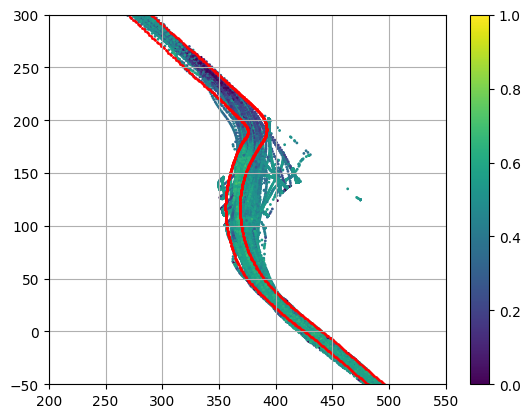

In [36]:
plt.scatter(f1_2022_df["WORLDPOSX"], f1_2022_df["WORLDPOSY"], c=f1_2022_df["ACCELERATION"], cmap='viridis',vmin=-40, vmax=40, alpha=1,s=1)
plt.scatter(ref_left["WORLDPOSX"], ref_left["WORLDPOSY"],s=1,c='red')
plt.scatter(ref_right["WORLDPOSX"], ref_right["WORLDPOSY"], s=1,c='red')
plt.xlim(200, 550)
plt.ylim(-50, 300)
plt.grid()
plt.colorbar()
plt.show()

In [18]:
f1_2022_df['ACCELERATION'].describe()

count    720744.000000
mean         -0.010178
std          11.148972
min       -1033.333333
25%           0.000000
50%           0.000000
75%           5.555556
max          38.888889
Name: ACCELERATION, dtype: float64

In [19]:
columns_to_print = ['SESSION_IDENTIFIER', 'FRAME', 'LAP_NUM', 'SECTOR', 'LAP_DISTANCE', 'CURRENT_LAP_TIME_MS', 'LAP_TIME_MS', 'SPEED_KPH', 'ACCELERATION']

session = f1_2022_df.loc[f1_2022_df['ACCELERATION'].idxmin()]
session = session[columns_to_print]
session['SESSION_IDENTIFIER']
session = f1_2022_df[f1_2022_df['SESSION_IDENTIFIER'] == session['SESSION_IDENTIFIER']]
session = session[columns_to_print]

session

# this shows that large negative acceleration suggests crash

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,LAP_TIME_MS,SPEED_KPH,ACCELERATION
336971,1.773021e+17,1436,1,0,0.440271,0,186380,213,0.000000
336972,1.773021e+17,1437,1,0,4.407611,66,186380,214,4.208754
336973,1.773021e+17,1438,1,0,7.389249,116,186380,214,0.000000
336974,1.773021e+17,1440,1,0,14.378124,233,186380,216,4.748338
336975,1.773021e+17,1441,1,0,17.384434,283,186380,216,0.000000
...,...,...,...,...,...,...,...,...,...
342418,1.773021e+17,8387,2,2,5196.442383,125120,126449,215,1.663340
342419,1.773021e+17,8389,2,2,5203.444336,125236,126449,216,2.394636
342420,1.773021e+17,8394,2,2,5216.523438,125453,126449,217,1.280082
342421,1.773021e+17,8401,2,2,5238.849609,125820,126449,220,2.270663


c:\Users\Issac\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='DISTANCE', ylabel='ACCELERATION'>

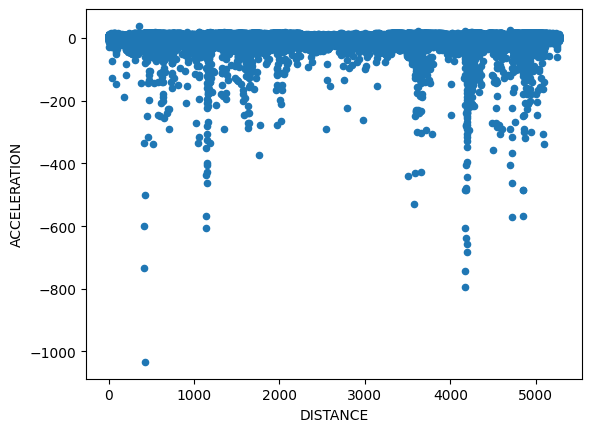

In [20]:
df = pd.DataFrame(
    {
        'ACCELERATION': f1_2022_df['ACCELERATION'], 
        'DISTANCE' : f1_2022_df['LAP_DISTANCE']
    }
    )
df.plot(kind='scatter', x='DISTANCE', y='ACCELERATION', colormap='viridis')
